# 확률론적 선형 회귀 모형

OLS(Ordinary Least Square) 방법을 사용하면 데이터에 대한 확률론적인 가정없이도 최적의 가중치를 계산할 수 있다. 그러나 이 경우에는 계산한 가중치가 어느 정도의 신뢰도 또는 안정성을 가지는지 확인할 수 있는 방법이 없다. 이를 확인하고자 하는 시도 중의 하나가 부트스트래핑(bootstrapping) 방법이다.

## 부트스트래핑

- 비모수적 추론. 특정 추정량의 확률적 성질을 수학적으로는 파악하기 힘든 상황에서 특히 유용. 주어진 데이터들을 원래의 모집단을 대표하는 독립 표본으로 가정하여 수집된 데이터들로부터 중복을 허용한 무작위 반복 추출을 하고 여기에서 얻은 통계량의 오차분산들을 활용하여 표본확률분포를 구한다.

부트스트래핑(bootstrapping)은 회귀 분석에 사용한 데이터가 달라진다면 회귀 분석의 결과는 어느 정도 영향을 받는지를 알기 위한 방법이다. 

데이터가 확률 변수로부터 생성된 표본이거나 혹은 더 큰 모집단 중에서 선택한 표본이라고 가정한다면 회귀 분석의 결과는 분석에 사용한 표본에 의존적임을 알 수 있다. 만약 추가적인 다른 표본을 얻어서 다시 회귀 분석에 사용한다면 회귀 분석 결과 즉, 가중치 벡터의 값은 달라질 것이다.

그러나 현실적으로는 데이터를 추가적으로 얻기가 힘들기 때문에 부트스트래핑 방법에서는 기존의 데이터를 재표본화(re-sampling)하는 방법을 선택한다. 재표본화는 기존의 $D$개의 데이터에서 다시 $D$개의 데이터를 선택하되 중복 선택도 가능하게 한다. (resampling with replacement) 이 경우 이론적으로는 $2^D$개의 새로운 표본 집단을 얻을 수 있다.

직접 부트스트래핑을 실시해 보자. 우선 100개의 가상 데이터를 생성하여 이를 기반으로 회귀 분석을 실시한다.

In [2]:
from sklearn.datasets import make_regression

X0, y, coef = make_regression(n_samples=100, n_features=1, noise=20, coef=True, random_state=0)

dfX0 = pd.DataFrame(X0, columns=["X1"])
dfX = sm.add_constant(dfX0)
dfy = pd.DataFrame(y, columns=["y"])

model = sm.OLS(dfy, dfX)
result = model.fit()
print(result.params)

const    -1.628364
X1       42.853356
dtype: float64


다음으로 이 데이터에서 중복을 허락하여 N개의 데이터를 선택한 후 다시 회귀 분석을 한다. 이론적으로 $2^{100}$개의 경우가 있지만 1,000번만 반복해 본다. N은 임의로 정해둔 것이다.

In [4]:
N = 1000
params_c = np.zeros(N)
params_x1 = np.zeros(N)
for i in range(N):
    idx = np.random.choice(len(dfy), len(dfy), replace=True) #replace=True: 중복을 허용한다는 의미
    dfX2 = dfX.ix[idx, :]
    dfy2 = dfy.ix[idx]
    r = sm.OLS(dfy2, dfX2).fit()
    params_c[i] = r.params.const
    params_x1[i] = r.params.X1

전체 가중치 집합을 히스토그램으로 나타내면 다음과 같다.

C:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


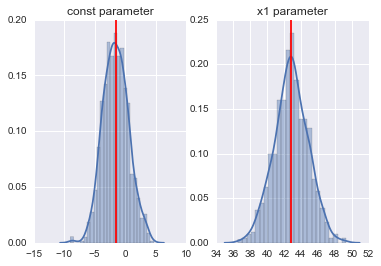

In [5]:
ax1 = plt.subplot(121)
sns.distplot(params_c, ax=ax1)
plt.axvline(params_c.mean(), c='r')
plt.title("const parameter")
ax2 = plt.subplot(122)
sns.distplot(params_x1, ax=ax2)
plt.axvline(params_x1.mean(), c='r')
plt.title("x1 parameter")
plt.show()

평균과 분산은 다음과 같다.

In [6]:
sp.stats.describe(params_c)

DescribeResult(nobs=1000, minmax=(-9.0198115291539427, 4.7088396783848747), mean=-1.5368190201040661, variance=4.3546263724741641, skewness=0.07464662168251654, kurtosis=0.00346308696337827)

In [7]:
sp.stats.describe(params_x1)

DescribeResult(nobs=1000, minmax=(36.527916302393841, 49.378570219987544), mean=42.842761388062861, variance=4.04756626960405, skewness=-0.009168152831402718, kurtosis=0.031507594225298696)

가중치 중 상수항의 경우 평균은 -1.6이지만 표분 편차가 $\sqrt{4.81}=2.19$이므로 0일 가능성을 배제할 수 없다.

이 결과를 statsmodels 의 회귀 분석 보고서와 비교하자.

In [8]:
print(result.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.803
Model:                            OLS   Adj. R-squared:                  0.801
Method:                 Least Squares   F-statistic:                     400.3
Date:                Wed, 07 Sep 2016   Prob (F-statistic):           2.21e-36
Time:                        09:20:51   Log-Likelihood:                -448.09
No. Observations:                 100   AIC:                             900.2
Df Residuals:                      98   BIC:                             905.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -1.6284      2.163     -0.753      0.4

보고서의 std err 항목을 보면 표준 편차의 경우 2.163 이고 마지막의 신뢰 구간(confidence interval)이 -5.920 ~ 2.663 임을 보이고 있다. 부트스트래핑으로 얻은 결과와 유사하다. 이 결과는 다음에 설명할 확률론적 가정에 의해 계산된 값이다.

## 확률론적 선형 회귀 모형

확률론적인 가정. 확률론적 선형 회귀 모형에서는 $y$가 확률 변수로부터 생성된 표본이라고 가정하며 다음과 같은 조건을 만족한다.


1. 선형 정규 분포 가정
 * 종속 변수 $y$는 기댓값 $w^Tx$, 분산 $\sigma^2$ 를 가지는 정규 분포 확률 변수이다.
   $$ p(y \mid x, \theta) = \mathcal{N}(y \mid w^Tx, \sigma^2 ) $$ 
 * 따라서 오차(disturbance)  $ \epsilon = y-w^Tx $ 도 정규 분포 확률 변수이다.
   $$ p(\epsilon \mid \theta) = \mathcal{N}(0, \sigma^2 ) $$ 

2. 외생성(Exogeneity) 가정
 * 오차 $\epsilon$와 독립 변수 $x$는 서로 독립이다.
   $$ \text{E}[\epsilon \mid x] = 0$$ 
   
3. 조건부 독립 가정
 * 오차 $\epsilon$는 $x$에 대해 조건부 독립이다.
   $$ \text{Cov}[\epsilon_i, \epsilon_j \mid x] =  0$$ 

* 오차와 x도 독립이고 오차i, j 둘끼리도 독립이다.
* 데이터를 뽑기 위한 모델 공간에 대해서 이야기 하고 있음.(노)

## MLE를 사용한 선형 회귀 분석

앞의 확률론적 선형 회귀 모형과 MLE(Maximum Likelihood Estimation)을 사용하여 가중치 벡터 $w$의 값을 구해보자.

Likelihood는 다음과 같다.


$$
\begin{eqnarray}
p(y_{1:N} \,\big|\, x_{1:N}, \theta)
&=& \prod_{i=1}^N N(y_i \,\big|\, w^T x_i , \sigma^2) \\
&=& \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{(y_i-w^T x_i)^2}{2\sigma^2} \right\}  \\
\end{eqnarray}
$$

계산을 용이하기 위해 Log를 취하면 다음과 같다.
$$
\begin{eqnarray}
\text{LL}  
&=& \log p(y_{1:N} \,\big|\, x_{1:N}, \theta) \\
&=& \log \prod_{i=1}^N \frac{1}{\sqrt{2\pi\sigma^2}}\exp\left\{-\frac{(y_i-w^T x_i)^2}{2\sigma^2} \right\}  \\
&=& -\dfrac{1}{2\sigma^2} \sum_{i=1}^N (y_i-w^T x_i)^2 + \dfrac{1}{2} \sum_{i=1}^N  \log{2\pi}{\sigma^2}  \\
\end{eqnarray}
$$



이를 행렬로 표시하면 다음과 같다.


$$
\text{LL}  =  -C_1 (y - Xw)^T(y-Xw) + C_0 = -C_1(w^TX^TXw -2 y^TXw + y^Ty) + C_0
$$

$$
C_1 =  -\dfrac{1}{2\sigma^2}
$$

$$
C_0 =  \dfrac{1}{2} \sum_{i=1}^N  \log{2\pi}{\sigma^2} 
$$

이를 최적화하면 OLS와 동일한 결과를 얻을 수 있다.


$$
\dfrac{\partial}{\partial w} \text{LL} \propto - 2X^TX \hat{w} + 2X^Ty = 0
$$

$$
\hat{w} = (X^TX)^{-1}X^T y
$$


확률적인 가정을 한 것과 안 한 것의 결과는 같다. 그러면 왜 했는가? 잔차의 분포에서 답이 나옴

## 잔차의 분포

위의 확률론적 선형 회귀 모형에 따르면 잔차 $e = y - \hat{w}^Tx$ 도 정규 분포를 따른다. 이는 다음과 같이 증명할 수 있다.

확률론적 선형 회귀 모형의 오차 $\epsilon$와 잔차 $e$는 다음과 같은 관계를 가진다.

$$  \hat{y} = X\hat{w} = X (X^TX)^{-1}X^T y = Hy $$

$$ e = y - \hat{y}= y - Hy = (I - H) y$$

$M = I - H$이라고 정의하면

$$ e = My = M (Xw + \epsilon) $$

최적화 조건에서

$$
X^TX \hat{w} - X^Ty = 0
$$

$$
X^T(X\hat{w} - y) = -X^Te = 0
$$

$$
X^TMy = 0 
$$

이 식은 모든 $y$에 대해 성립하므로

$$
X^TM = 0
$$

$H$가 대칭 행렬이므로 $M = I -H$도 대칭 행렬

$$
MX = 0
$$


$$ e = MXw + M\epsilon = M\epsilon $$

즉, 잔차 $e$는 오차 $\epsilon$의 선형 변환(linear transform)이다. 정규 분포의 선형 변환은 마찬가지로 정규 분포이므로 잔차도 정규 분포를 다른다.

핵심은 residual(e)가 정규분포가 된다. 노말이 된다.

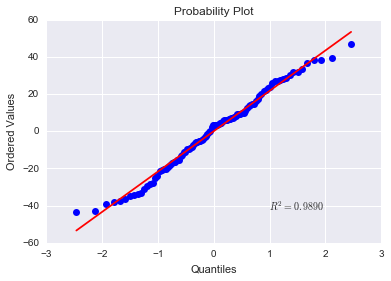

In [9]:
sp.stats.probplot(result.resid, plot=plt)
plt.show()

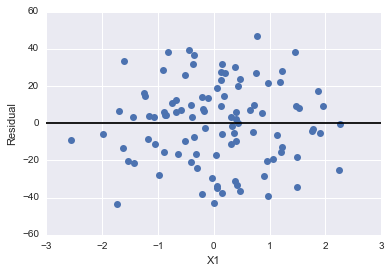

In [11]:
plt.plot(X0, result.resid, 'o')
plt.axhline(y=0, c='k')
plt.xlabel('X1')
plt.ylabel('Residual')
plt.show()

In [12]:
import statsmodels.stats.api as sms

In [13]:
test = sms.omni_normtest(result.resid)
for x in zip(['Chi^2', 'P-value'], test):
    print("%-12s: %6.3f" % x)

Chi^2       :  3.523
P-value     :  0.172


In [14]:
test = sms.jarque_bera(result.resid)
for x in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test):
    print("%-12s: %6.3f" % x)

Jarque-Bera :  2.059
P-value     :  0.357
Skew        : -0.073
Kurtosis    :  2.312


## 회귀 계수의 표준 오차

w를 정확히 구할 수는 없다. 그러나 분포를 구할 수는 있다.

가중치 $\hat{w}$ 도 정규 분포 확률 변수인 $y$의 선형 변환이므로 정규 분포를 따른다.

$$  
\begin{eqnarray}
\hat{w} 
&=& (X^TX)^{-1} X^T y \\
&=& (X^TX)^{-1} X^T (X w + \epsilon) \\
&=& w - (X^TX)^{-1} X^T \epsilon \\
\end{eqnarray}
$$

따라서 가중치의 기댓값은 다음과 같다.

$$  
\begin{eqnarray}
\text{E}[\hat{w}] 
&=&  \text{E}[ w - (X^TX)^{-1} X^T \epsilon ] \\
&=&  w - (X^TX)^{-1} X^T \text{E}[ \epsilon ] \\
&=& w
\end{eqnarray}
$$


가중치의 분산을 계산하면 다음과 같다.


$$
\begin{eqnarray}
\text{Var}[\hat{w}] 
&=& E[(\hat{w} - w)(\hat{w} - w)^T] \\
&=& E[((X^TX)^{-1} X^T \epsilon)((X^TX)^{-1} X^T \epsilon)^T] \\
&=& E[(X^TX)^{-1} X^T \epsilon \epsilon^T X(X^TX)^{−1} ] \\
&=& (X^TX)^{-1} X^T E[\epsilon \epsilon^T] X(X^TX)^{−1} \\
&=& (X^TX)^{-1} X^T (\sigma^2 I) X(X^TX)^{−1} \\
&=& \sigma^2  (X^TX)^{-1}
\end{eqnarray}
$$


$\sigma^2$의 값은 알지 못하므로 다음과 같이 추정한다.

$$ s^2 = \dfrac{e^Te}{N-K} = \dfrac{RSS}{N-K} $$
여기에서 $N$은 표본 데이터의 수, $K$는 독립 변수의 수이다.

따라서 $\hat{w}$의 variance의 추정값은 
$$ \text{Est.Var}[\hat{w}]  = s^2(X^TX)^{-1}$$
이다.

이 값에서 구한 표준 편차를 회귀 계수의 표준 오차(Standard Error of Regression Coefficient)라고 한다.

 $$ {se_i} = \sqrt{s^2 \big((X^TX)^{-1}\big)_{ii}} $$

## 단일 계수 t-검정 (Single Coefficient t-test)

오메가 자체는 정규 분포다.

$\hat{w}$을 위에서 구한 표준 오차로 나눈 값은 자유도가 $N-K$인 student-t 분포를 따른다.

$$  \dfrac{\hat{w}_i - w_i}{se_i} \sim t_{N-K} $$

이를 검정 통계량(test statistics)로 사용하면 특정 회귀 계수(선형 회귀 모형의 각각의 가중치 벡터) $w_i$가 0 인지 아닌지에 대해 조사할 수 있다.

$$ H_0 : \;\; w_i = 0 $$
 

## Loss-of-Fit test (Regression F-test)

개별 개수가 아닌 전체 회귀 계수에 대해 다음과 같은 귀무 가설을 생각하자.

$$ H_0 : w_1  = w_2 = \cdots = w_K = 0 $$

이는 전체 독립 변수 중 어느 것도 의미를 가진 것이 없다는 뜻이다. 즉 선형 회귀 분석 자체가 얼마나 의미있는지를 알 수 있다. 이러한 귀무 가설을 검정하는 것을 Loss-of-Fit test (Regression F-test)이라고 한다.

F-검정은 모든 계수 $w_i$가 0이면 $R^2 = 0$ 이라는 사실을 이용한다. $R^2 = 0$ 이면 다음 test-statistics는 F 분포를 따른다.

$$ \dfrac{R^2/(K-1)}{(1-R^2)(N-K)} \sim F(K-1, N-K) $$

* N은 데이터의 개수, K는 파라미터의 개수
* F검정은 모형과 모형을 비교하기 위해서